# Segmentation on testicular germ cell tumors data 

The data used to train the model below is in: 

(google drive)/Donnes_patients/data_of_FPN_model.zip

along with the trained model ("best_model.h5")

## More equilibrated dataset: 
The more equilibrated dataset is called "less_empty.zip" and it can be found at:

MyDrive/Donnes_patients/less_empty.zip

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr  4 20:34:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading libraries & installing packages

In [2]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 8.9 MB/s 


In [3]:
!pip install mlflow

     |████████████████████████████████| 16.5 MB 8.0 MB/s 
     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 62 kB 856 kB/s 
     |████████████████████████████████| 210 kB 54.3 MB/s 
     |████████████████████████████████| 596 kB 38.9 MB/s 
     |████████████████████████████████| 181 kB 45.9 MB/s 
     |████████████████████████████████| 146 kB 37.6 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.6-py3-none-any.whl size=112631 sha256=969cfc9a0e51992bf5b4d277fd2dac482801a802bbdd08d9a8ac122cd57b73f0
  Stored in directory: /root/.cache/pip/wheels/96/c1/f8/d75a22e789ab6a4dff11f18338c3af4360189aa371295cc934
Successfully built databricks-cli
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [4]:
#below is to prevent keras segmentation models 'str' object has no attribute 'decode' error with segmentation models
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 8.0 MB/s 
     |████████████████████████████████| 15.7 MB 39.7 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

In [5]:
import numpy as np
import glob2
import pandas as pd
from sklearn.model_selection import train_test_split
import os, shutil
import tensorflow as tf
import pydicom
import glob2
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import tqdm
import itertools
import mlflow
import numpy as np
import keras
import pandas as pd
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import *
from keras_preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2

## Housekeeping
The data is in:
(google drive)/Donnes_patients/data_of_FPN_model.zip

as a .zip folder with train, val, test groups already separated as subfolders.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# copying patient data into the session
!cp /content/gdrive/MyDrive/Donnes_patients/less_empty.zip /content/

In [ ]:
# copying patient data into the session
#!cp /content/gdrive/MyDrive/Donnes_patients/data_of_FPN_model.zip /content/

In [8]:
!unzip -q /content/less_empty.zip 

In [ ]:
#test_home_path = '/content/content/content/Donnes_patients/DATA'

Inside this .zip folder the masks are already added together and inside the folders of the patients they belong.

Therefore skipping directly to the **DATA GENERATOR** part.

In [ ]:
patient_num=2
node_paths = []
glob_list = glob2.glob(os.path.join(test_home_path + f'*/*ID{patient_num}*/*.npy'))
nodes = [el.split('/')[-2].split('_')[-1] for el in glob_list]
node_list = list(set(nodes)) # Here we have a list with the name of the lymph nodes (like [L1, L2, L3, etc.])
node_list
for i in range(len(node_list)):
  node_paths = []
  path = glob2.glob(os.path.join(test_home_path + f'*/*ID{patient_num}' + '_' + node_list[i] + '/*.npy'))
  node_paths.append(path)
node_paths




#### Deniz's code + fix (thank you so much for fixing it)

In [ ]:
def mask_addition(home_path, patient_num):
  '''Given the root data path (str) and the patient number (int) as argument,
  this function returns a dataframe of the sorted mask paths with lymph_node names as colums'''
  glob_list = glob2.glob(os.path.join(home_path + f'*/*ID{patient_num}*/*.npy'))
  nodes = [el.split('/')[-2].split('_')[-1] for el in glob_list]
  node_list = list(set(nodes)) # Here we have a list with the name of the lymph nodes (like [L1, L2, L3, etc.])
  sorted_paths = []
  sorted_masks = []
  node_paths = []


  for i in range(len(node_list)):

    node_paths =[]
    path = glob2.glob(os.path.join(home_path + f'*/*ID{patient_num}' + '_' + node_list[i] + '/*.npy'))
    node_paths.append(path)
    #when printed node_paths gives "home_path/ID{patient_number}_L1/*.npy" , "home_path/ID{patient_number}_L2/*.npy" , "home_path/ID{patient_number}_L3/*.npy"
    #but when returned it only returns "home_path/ID{patient_number}_L1/*.npy" (only files belonging to L1 (the first item of the iteration))
    #sorting the mask paths

    for item in node_paths:
      
      sorted_paths = []
      new_sorted_paths = sorted(item, key=lambda x:int(x.split('/')[-1].split('_')[-1].split('.npy')[0]))
      #sorted_paths.append(new_sorted_paths)
      #print(sorted_paths)
      sorted_masks.append([file for file in new_sorted_paths if 'mask' in file])

  #creating dataframe
  dataframe = pd.DataFrame(np.array(sorted_masks).transpose(), columns=node_list)
  dataframe.to_csv(f'{home_path}ID{patient_num}.csv', index=None)

    #creating numpy array from the datraframe
    #for i in range(dataframe.shape[0]):
    # mega_mask = dataframe.loc[i,:].values
    #  empty = np.zeros((512,512))
    #  for m in mega_mask:
    #    empty+=np.load(m)
    #    np.save(f'{home_path}/ID{patient_num}_mask.npy', empty)
  return dataframe

### Refactored code :
- logic separated in 2 steps: dataframes generation (aligned masks & images)
- mask composition (=superposition)
- minimal testing

In [ ]:
/content/content/Donnes_patients/DATA/NIFTI_PATIENT_ID2_L1/image_0.npy

In [ ]:
os.path.join(test_home_path , f'*ID1*/*.npy')

'/content/content/Donnes_patients/DATA/*ID1*/*.npy'

In [ ]:
glob2.glob(os.path.join(test_home_path + f'*/*ID1*/*.npy'))

[]

In [ ]:

from matplotlib.path import Path
import multiprocessing
import time
from multiprocessing import Process 


def mask_addition_v2(home_path, patient_ID):
  '''Given the root data path (str) and the patient number (int) as argument,
  this function returns a dataframe of the sorted mask paths with lymph_node names as colums'''

  glob_list = glob2.glob(os.path.join(home_path + f'*/*ID{patient_ID}*/*.npy'))
  nodes = [el.split('/')[-2].split('_')[-1] for el in glob_list]
  node_list = list(set(nodes)) # Here we have a list with the name of the lymph nodes (like [L1, L2, L3, etc.])
  
  # place holders for masks and images before any operation
  sorted_masks = []
  sorted_images = []


  for node_l in node_list:
    path = glob2.glob(os.path.join(home_path + f'*/*ID{patient_ID}_{node_l}/*.npy'))
    new_sorted_paths = sorted(path, key=lambda x:int(x.split('/')[-1].split('_')[-1].split('.npy')[0]))

    sorted_masks.append([file for file in new_sorted_paths if 'mask' in file])
    sorted_images.append([file for file in new_sorted_paths if 'image' in file])

  # creating dataframe 
  # (lists shape: node_list * nslices)
  # need to transpose the lists

  print(node_list)
  mask_dataframe = pd.DataFrame(np.array(sorted_masks).transpose(), columns=node_list)
  image_dataframe = pd.DataFrame(np.array(sorted_images).transpose(), columns=node_list)



  mask_dataframe.to_csv(f'{home_path}ID{patient_ID}_mask.csv', 
                        index=None, 
                        sep=',')
  image_dataframe.to_csv(f'{home_path}ID{patient_ID}_image.csv', 
                         index=None, 
                         sep=',')

  return mask_dataframe, image_dataframe



def generate_added_masks(df, home_path):
  '''
  takes a dataframe of size nobs*k and sums all the k masks
  resulting in nobs masks(numpy array)
  '''

  # creating numpy array from the aligned datraframe
  # the patient number/ID can be infered by the first element of the dataframe

  patient_ID= int(df.iloc[0,0].split("_")[-3][2:])
  print(f">>>Generating Masks for patient {patient_ID}")

  for i in tqdm.tqdm(range(df.shape[0])):
   
    mega_mask = df.loc[i,:].values
    empty = np.zeros((512,512))
    os.makedirs(f'{home_path}/neomasks', exist_ok=True)
    for mask in mega_mask:
      empty+=np.load(mask)
      np.save(f'{home_path}/neomasks/ID{patient_ID}_composite_mask_{i}.npy', empty)
  print(f"patient: {patient_ID} is 100% processed")



def saftey_tests(msk_dataframe, img_dataframe):
  '''
  safety checks (minimal testing)
  '''
  c1 = msk_dataframe.columns[0]
  assert "mask" in msk_dataframe.loc[0, c1], "the naming for mask data is incorrect"
  assert "image" in img_dataframe.loc[0, c1], "the naming for image data is incorrect"
  assert msk_dataframe.loc[0, c1].split("/")[-2] == img_dataframe.loc[0, c1].split("/")[-2], "the patient ids for masks and images dont match"
  assert msk_dataframe.loc[0, c1].split("/")[-1].split("_")[-1] == img_dataframe.loc[0, c1].split("/")[-1].split("_")[-1], "the series slice numbers dont match"
  print("tests passed")


def mask_generation_process(all_patients_list, home_path):
  '''
  saves the composite mask for each patient
  used for processing. patients in parallel if needed
  '''

  # we determine automatically the max number of patients 
  patient_id_max = max([int(el.split("_")[-3][2:]) for el in all_patients_list])

  # iterate over each patient (1-indexing)
  for p_num in range(1, patient_id_max+1, 1):
    try:
      print(f">>> processing patient : {p_num}")
      msk_dataframe, img_dataframe = mask_addition_v2(home_path=home_path, 
                                                    patient_ID=p_num)

      # safety checks @ each iteration
      saftey_tests(msk_dataframe, 
                  img_dataframe)
      
      # save the composite masks
      generate_added_masks(msk_dataframe, 
                          home_path=home_path)
    except ValueError:
      print("NIFTI data was not extracted for this patient")
      pass
    

def process_mask_workers(home_path):
  '''
    curryied/decorated  function   
  '''


  def single_mask_generation_process_v3(p_num, home_path=home_path):
    '''
    saves the composite mask for each patient
    '''

    msk_dataframe, img_dataframe = mask_addition_v2(home_path=home_path, 
                                                    patient_ID=p_num)
    # safety checks @ each iteration
    saftey_tests(msk_dataframe, 
                  img_dataframe)
    
    # save the composite masks
    generate_added_masks(msk_dataframe, 
                          home_path=home_path)

  return single_mask_generation_process_v3


#### EX: example of usage for 1 patient

In [ ]:
# generate the masks for the patients id (example for patient 2)
msk_dataframe, img_dataframe = mask_addition_v2(home_path=test_home_path, 
                                                patient_ID=4)

['L2', 'L1']


In [ ]:
# the function generates the added masks
generate_added_masks(msk_dataframe, test_home_path)

>>>Generating Masks for patient 4


100%|██████████| 681/681 [00:12<00:00, 53.47it/s]

patient: 4 is 100% processed


#### EX: Usage for all patients (non multiprocessing)

In [ ]:
start = time.time()
black_listed_ID = 1

all_patients_list = [el for el in glob2.glob(os.path.join(test_home_path + f'*/*ID*/*.npy')) ]

mask_generation_process(all_patients_list, 
                        test_home_path)

end = time.time()
print(end-start)

#### EX: Usage for patients (multiprocessing version) 
- 15% faster with 3 cpu and 4 patients
- to benchmark with growing patients

In [ ]:
!sudo apt-get install tree

In [ ]:
!tree -f /content/content/Donnes_patients/DATA/test

In [ ]:
if __name__ == "__main__":   
    start = time.time()
    processes = []

    fun = process_mask_workers(test_home_path)

    # if more patients limit the number of processes to
    # multiprocessing.cpu_count
    workers = multiprocessing.cpu_count()-1

    # we determine automatically the max number of patients 
    all_patients_list = glob2.glob(os.path.join(test_home_path + f'*/*ID*/*.npy'))
    p_num_max = max([int(el.split("_")[-3][2:]) for el in all_patients_list])
    print(f"there are: {workers} workers")
    print(f"there are : {p_num_max} patients in total")

    #for p_num in range(0, 1 + (p_num_max//workers), 1):
    p_num = 1
    process_on= True

    while process_on:
      for i in range(0, workers,1):

        if i+p_num <= p_num_max:
          p = Process(target=fun, args=(i+p_num,))
          p.start()
          processes.append(p)
        else:
          process_on = False
          break
      if processes:    
        for p in processes:
              p.join() # call to ensure subsequent line (e.g. restart_program) 
                      # is not called until all processes finish

      p_num += workers
     
      end = time.time()
    print(end -start)

## Data Generator

In [9]:
import tensorflow

In [10]:
from skimage.util import random_noise
from PIL import Image
import numpy as np
from imgaug import augmenters as iaa
import random

In [11]:
class DataGenerator(tensorflow.keras.utils.Sequence):
  def __init__(self, df, modality="train", batch_size=1, dim=(500,500), n_channels=3, n_classes=3, shuffle=True, rgb=True, post_treatment=True):

    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.rgb = rgb
    self.post_treatment = post_treatment

    # in case the image paths are different , you might have to modify them
    #self.dataframe["mask_path"] = self.dataframe["mask_path"].apply(lambda x:x.replace(OLD_HOME,NEW_HOME))

    # in case the mask paths are different , you might have to modify them                                                                                             
    #self.dataframe["im_path"] = self.dataframe["im_path"].apply(lambda x:x.replace(OLD_HOME,NEW_HOME))
                                                                                                      
    # get data in and shuffle
    self.dataframe = df.reset_index(drop=True).sample(frac=1)
        
    # get the ID list
    self.list_IDs = list(self.dataframe.index)
        
        # depending on the models u must specify a given number of channels (3 or 1)
    self.n_channels = n_channels
        
    # n classes (binary problem or categorical problem 
    # you can use this parameter for to_categorical for ex)

    self.n_classes = n_classes
    self.shuffle = shuffle

    # simple conversion dictionary
    self.map = {"patho":1,"non_patho":0}
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))
  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    self.list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(self.list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  #draw image on mask at the end of each epoch for example
  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' 
    # X : (n_samples, *dim, n_channels)
    # y : (n_samples, *dim, n_channels)

    # Initialization

    # images
    if self.rgb:

      X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float16)

    else:
      X = np.empty((self.batch_size, *self.dim, 1), dtype=np.float16)

    # masks
    y = np.empty((self.batch_size, *self.dim, 1))

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
            
        # Store sample
        # you might want to convert the data to np.uint8 if needed
        # can try to train on raw data as well
        im = np.load(self.dataframe.loc[ID,"image_path"]) # we can resize the image at this step
        im = cv2.resize(im, dsize=(500, 500))
        im = im.astype(np.uint8)
        
        # data augmentation (add noise, etc.) TO DO add random transformations
        my_random = random.randint(1,10)
        if my_random > 5:
          aug = iaa.AdditiveGaussianNoise(loc=0, scale=0.1*255) #Gausian noise
          im = aug.augment_image(im)
        # salt and pepper noise
        aug = iaa.SaltAndPepper(p=0.05)
        im = aug.augment_image(im)

        # Store mask:
        # the mask values must be between 0 and 1
        mask = np.load(self.dataframe.loc[ID,"mask_path"]) /255.  #we can resize the image at this step
        mask = cv2.resize(mask, dsize=(500, 500))
        #image of mask is /255 (resizing should be before this division)    
        if self.post_treatment:

          im = im.astype(np.uint8)

        if self.rgb:

          X[i,] = cv2.merge([im, im, im]) # convert the image (numpy array in to rgb)
                                          #gives a dimension (shape) of (512,512,3)
        else: 
          X[i,] = np.expand_dims(im, axis=-1)

        # Store class
        y[i] = np.expand_dims(mask, axis=-1)     #to_categorical(mask, num_classes=self.n_classes) 
                    # depending on your loss function 
                    # (you might have to convert it to a 
                    # mask of size 512x 512x nclasses like below)

    return X, y

In [ ]:
############

In [12]:
train_data = glob2.glob('/content/content/less_empties/train_new/*/*.npy')

In [13]:
len(train_data)

3228

In [14]:
train_images = [file for file in train_data if 'mask' not in file]
train_masks = [file for file in train_data if 'mask' in file]

In [15]:
print(len(train_images), len(train_masks))

1614 1614


In [16]:
val_data = glob2.glob('/content/content/less_empties/val_new/*/*.npy')
val_images = [file for file in val_data if 'mask' not in file]
val_masks = [file for file in val_data if 'mask' in file]
print(len(val_images), len(val_masks))

338 338


In [17]:
test_data = glob2.glob('/content/content/less_empties/test_new/*/*.npy')
test_images = [file for file in test_data if 'mask' not in file]
test_masks = [file for file in test_data if 'mask' in file]
print(len(test_images), len(test_masks))

571 571


##How many of the masks' images have something in it? 


In [ ]:
not_empties = []
for file in train_masks:
  mask = np.load(file)
  if len(np.unique(mask)) > 1 :
    not_empties.append(file)

print(f'There are {len(train_masks)} in the training set and {len(not_empties)} are full')

There are 1614 in the training set and 930 are full


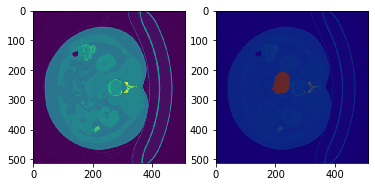

In [104]:
im = np.load('/content/content/less_empties/train_new/ID2/image_512.npy')
immask = np.load('/content/content/less_empties/train_new/ID2/ID2_composite_mask_512.npy')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, interpolation='none')
plt.imshow(immask, 'jet', interpolation='none', alpha=0.7)
plt.show()

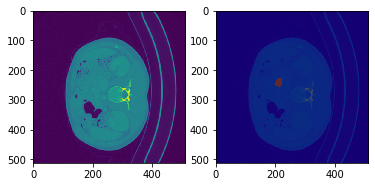

In [ ]:
val_im = np.load('/content/content/less_empties/val_new/NIFTI_PATIENT_ID17/image_479.npy')
val_immask = np.load('/content/content/less_empties/val_new/NIFTI_PATIENT_ID17/ID17_composite_mask_479.npy')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(val_im, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(val_im, interpolation='none')
plt.imshow(val_immask, 'jet', interpolation='none', alpha=0.7)
plt.show()

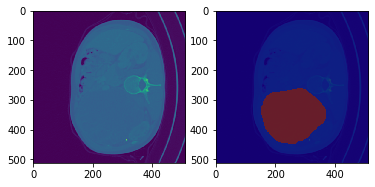

In [ ]:
im = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/image_60.npy')
immask = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/ID9_composite_mask_60.npy')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, interpolation='none')
plt.imshow(immask, 'jet', interpolation='none', alpha=0.7)
plt.show()

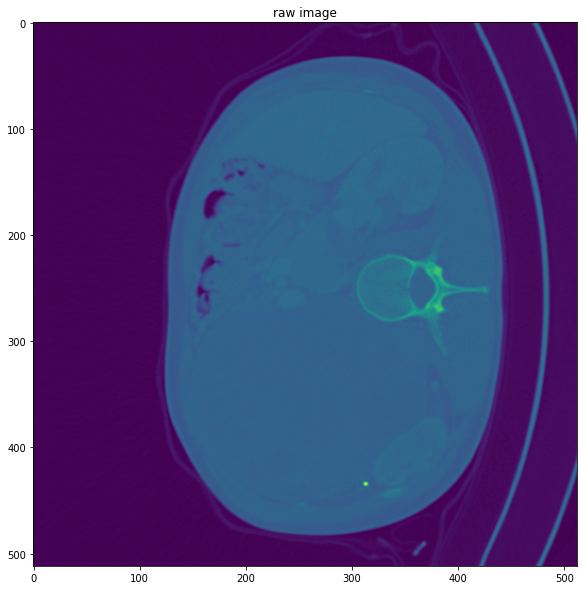

In [ ]:
##### image transformation so that there is more visibility
im = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/image_60.npy')
plt.figure(figsize=(10,10))
plt.title('raw image') #ajouter quadrillage
plt.imshow(im)
plt.show()

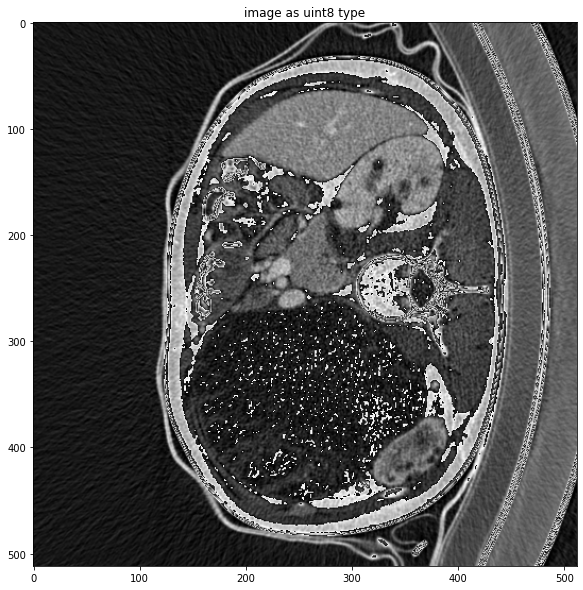

In [ ]:
im = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/image_60.npy')
im2 = im.astype(np.uint8)
plt.figure(figsize=(10,10))
plt.title('image as uint8 type')
#ehalisation de histogramme pour améliorer le contrast (to do)
plt.imshow(im2, cmap='gray')
plt.show()

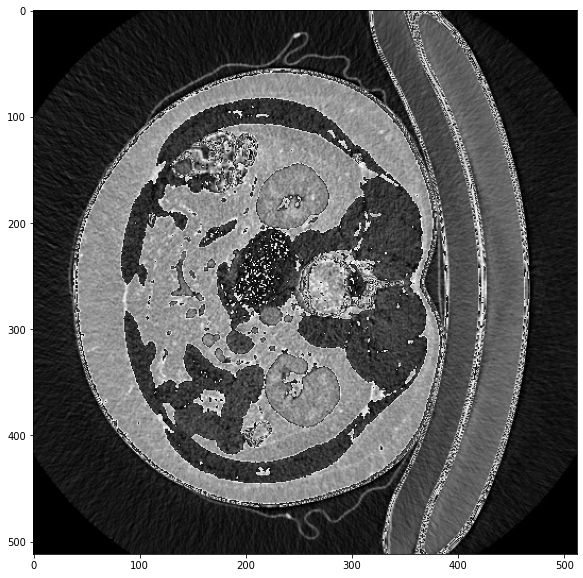

In [ ]:
im_id2 = np.load('/content/content/less_empties/train_new/ID2/image_512.npy')
im_id2_2 = im_id2.astype(np.uint8)
plt.figure(figsize=(10,10))
plt.imshow(im_id2_2, cmap='gray')
plt.show()

In [ ]:
train_df = pd.DataFrame(list(zip(train_images, train_masks)), columns = ['image_path', 'mask_path'])
val_df = pd.DataFrame(list(zip(val_images, val_masks)), columns = ['image_path', 'mask_path'])
test_df = pd.DataFrame(list(zip(test_images, test_masks)), columns = ['image_path', 'mask_path'])

In [ ]:
train_csv = train_df.to_csv('train.csv', index=None)
val_csv = val_df.to_csv('val.csv', index=None)
test_csv = test_df.to_csv('test.csv', index=None)

In [18]:
train_set = pd.read_csv('train1.csv')
train_set.head()

,image_path,mask_path
0,/content/content/less_empties/train_new/ID11/i...,/content/content/less_empties/train_new/ID11/I...
1,/content/content/less_empties/train_new/ID11/i...,/content/content/less_empties/train_new/ID11/I...
2,/content/content/less_empties/train_new/ID11/i...,/content/content/less_empties/train_new/ID11/I...
3,/content/content/less_empties/train_new/ID11/i...,/content/content/less_empties/train_new/ID11/I...
4,/content/content/less_empties/train_new/ID11/i...,/content/content/less_empties/train_new/ID11/I...


In [19]:
train_set = pd.concat([train_set]*2, axis=0)
train_set = train_set.sample(frac=1)
# shuffle 

In [20]:
print(train_set.shape)

(3228, 2)


In [21]:
val_set = pd.read_csv('val1.csv')
test_set = pd.read_csv('test1.csv')

In [22]:
val_set.head()

,image_path,mask_path
0,/content/content/less_empties/val_new/NIFTI_PA...,/content/content/less_empties/val_new/NIFTI_PA...
1,/content/content/less_empties/val_new/NIFTI_PA...,/content/content/less_empties/val_new/NIFTI_PA...
2,/content/content/less_empties/val_new/NIFTI_PA...,/content/content/less_empties/val_new/NIFTI_PA...
3,/content/content/less_empties/val_new/NIFTI_PA...,/content/content/less_empties/val_new/NIFTI_PA...
4,/content/content/less_empties/val_new/NIFTI_PA...,/content/content/less_empties/val_new/NIFTI_PA...


In [23]:
test_set.head()

,image_path,mask_path
0,/content/content/less_empties/test_new/NIFTI_P...,/content/content/less_empties/test_new/NIFTI_P...
1,/content/content/less_empties/test_new/NIFTI_P...,/content/content/less_empties/test_new/NIFTI_P...
2,/content/content/less_empties/test_new/NIFTI_P...,/content/content/less_empties/test_new/NIFTI_P...
3,/content/content/less_empties/test_new/NIFTI_P...,/content/content/less_empties/test_new/NIFTI_P...
4,/content/content/less_empties/test_new/NIFTI_P...,/content/content/less_empties/test_new/NIFTI_P...


In [24]:
#creating the data generators
train_generator = DataGenerator(train_set)
val_generator = DataGenerator(val_set)
test_generator = DataGenerator(test_set)

In [ ]:
print(val_generator[1][0][0])

##verify that images load correctly

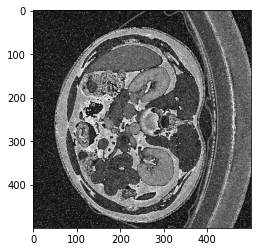

In [25]:
val_image = val_generator[1][0][0]
#val_image2 = np.squeeze(val_image, axis=-1)
plt.imshow((val_image).astype(np.uint8))
plt.show() #TO DO add title to this image

In [ ]:
print(val_image)

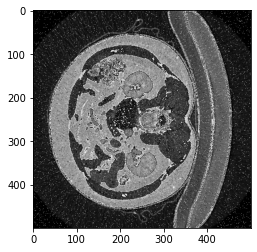

In [26]:
train_image = train_generator[20][0][0]
#val_image2 = np.squeeze(val_image, axis=-1)
plt.imshow((train_image).astype(np.uint8))
plt.show() #TO DO add title to this image

## Training
Using segmentation models from Keras

In [27]:
from keras.layers import Dense, Dropout
from keras.callbacks import *

In [28]:
!pip3 install -U segmentation-models

     |████████████████████████████████| 50 kB 6.8 MB/s 


In [29]:
import tensorflow.keras.backend as K

In [30]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_unet.h5', 
                                    save_weights_only=True, 
                                    save_best_only=True, 
                                    mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]


In [32]:
BACKBONE = 'resnet101' #try resnet 101
BATCH_SIZE = 1
CLASSES = ['LN']
LR = 0.001
EPOCHS = 15
input_shape = (500,500,3)
preprocess_input = sm.get_preprocessing(BACKBONE)

In [33]:
from segmentation_models import Unet, FPN

In [34]:
from keras.applications import vgg16
from keras.models import Model,load_model

In [35]:
VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
print('Model loaded.')

58900480/58889256 [==============================] - 0s 0us/step
Model loaded.


In [36]:
output_ = VGG16.output
output_

<KerasTensor: shape=(None, 15, 15, 512) dtype=float32 (created by layer 'block5_pool')>

In [37]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


In [38]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

In [39]:
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation

In [40]:
def ModelEnhancer():
    input_shape = (500, 500, 3)
    VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    last_layer = VGG16.output
    
    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False
            
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)    
    
    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    '''model_ = Conv2D(32,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)'''
    
    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Model(VGG16.input,model_)
    
    return model_

In [41]:
Model_ = ModelEnhancer()
Model_.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 500, 500, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 500, 500, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

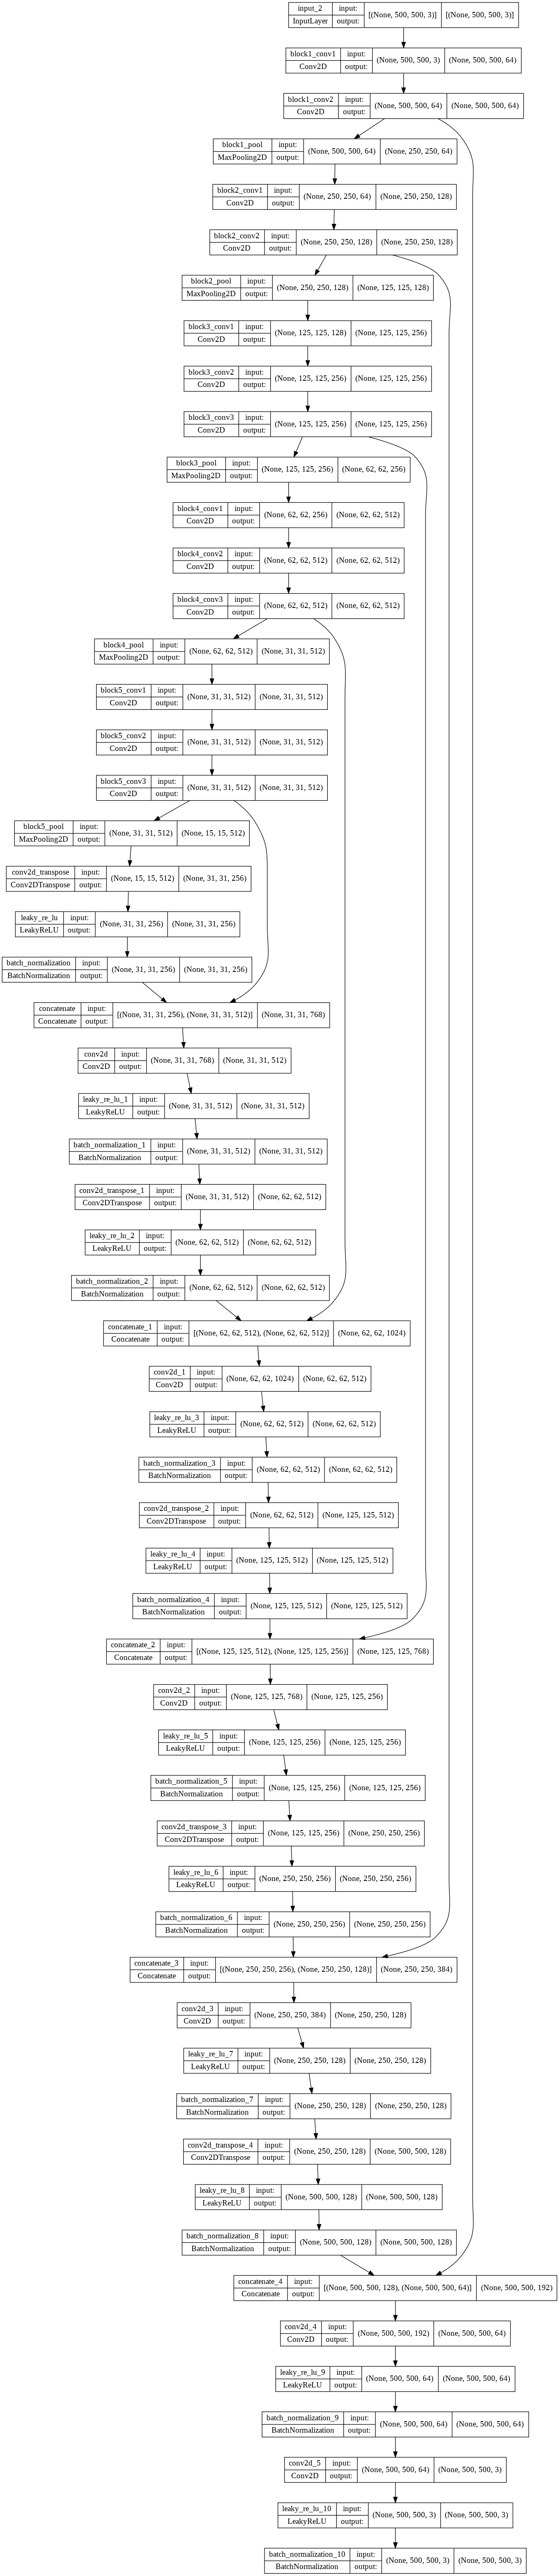

In [42]:
from keras.utils.vis_utils import plot_model
plot_model(Model_,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [43]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
# define optimizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
Model_.compile(optim, total_loss, metrics)

In [44]:
checkpointer = ModelCheckpoint('model_TL_UNET.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

In [45]:
history = Model_.fit_generator(
    train_generator, 
    steps_per_epoch=len(train_generator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val_generator, 
    validation_steps=len(val_generator),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/15
3228/3228 [==============================] - 589s 178ms/step - loss: 2.0168 - iou_score: 0.0046 - f1-score: 0.0089 - val_loss: 1.2218 - val_iou_score: 6.3880e-04 - val_f1-score: 0.0013 - lr: 0.0010
Epoch 2/15
3228/3228 [==============================] - 571s 177ms/step - loss: 1.2179 - iou_score: 0.0254 - f1-score: 0.0299 - val_loss: 1.1172 - val_iou_score: 0.2892 - val_f1-score: 0.2895 - lr: 0.0010
Epoch 3/15
3228/3228 [==============================] - 571s 177ms/step - loss: 1.0440 - iou_score: 0.1873 - f1-score: 0.1875 - val_loss: 1.0229 - val_iou_score: 0.2683 - val_f1-score: 0.2683 - lr: 0.0010
Epoch 4/15
3228/3228 [==============================] - 571s 177ms/step - loss: 1.0025 - iou_score: 0.3761 - f1-score: 0.3764 - val_loss: 0.9951 - val_iou_score: 0.5828 - val_f1-score: 0.5828 - lr: 0.0010
Epoch 5/15
3228/3228 [==============================] - 570s 177ms/step - loss: 0.9690 - iou_score: 0.2222 - f1-score: 0.2263 - val_loss: 1.0180 - val_iou_score: 0.1601 - val_f

In [46]:
print(history.history.keys())

dict_keys(['loss', 'iou_score', 'f1-score', 'val_loss', 'val_iou_score', 'val_f1-score', 'lr'])


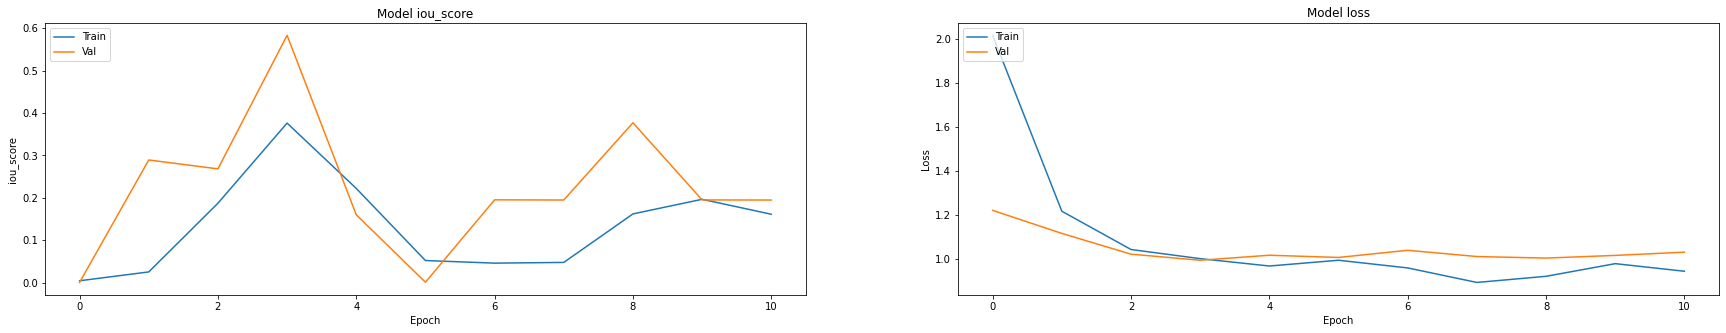

In [48]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [50]:
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.99206
mean iou_score: 0.82312
mean f1-score: 0.82312


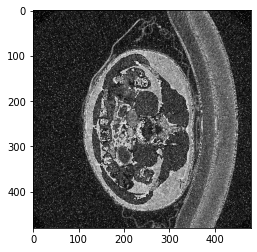

In [ ]:
val_image = val_generator[1][0][0]
#val_image2 = np.squeeze(val_image, axis=-1)
plt.imshow(val_image.astype(np.uint8))
plt.show()

In [ ]:
np.unique(val_image.astype(np.uint8))

## Model Evaluation

In [49]:
test_dataloader = DataGenerator(test_set, batch_size=1, shuffle=False)
# load best weights
Model_.load_weights('/content/best_model_unet.h5') 
scores = Model_.evaluate_generator(test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


In [51]:
#obtaining predictions on the test batch
test_preds = Model_.predict(test_generator)

In [52]:
test_preds.shape

(571, 500, 500, 3)

In [53]:
# 1st item of this tensor
test_preds[0].shape

(500, 500, 3)

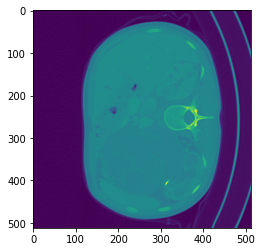

In [55]:
img_test = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/image_67.npy')
plt.imshow(img_test)
plt.show()

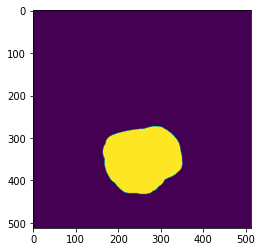

In [56]:
mask_test = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/ID9_composite_mask_67.npy')
plt.imshow(mask_test)
plt.show()

In [57]:
#image to predict need to have same dimensions as the model
# (1, 512,512,3)
testing_image = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID9/image_67.npy')
testing_image = cv2.resize(testing_image, dsize=(500, 500))
testing_image = cv2.merge([testing_image,testing_image,testing_image])

In [58]:
testing_image.shape

(500, 500, 3)

In [59]:
new_testing_image = np.expand_dims(testing_image, axis=0)
new_testing_image.shape

(1, 500, 500, 3)

In [105]:
#new_testing_image2 = np.expand_dims(new_testing_image, axis=3)

In [106]:
#new_testing_image2.shape

(1, 500, 500, 1, 3)

In [60]:
prediction = Model_.predict(new_testing_image)

In [90]:
a = np.squeeze(prediction, axis=0)
a.shape

(500, 500, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


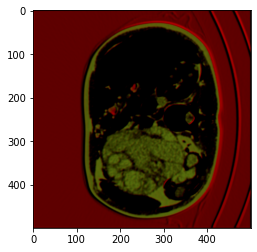

In [91]:
plt.imshow(a)
plt.show()

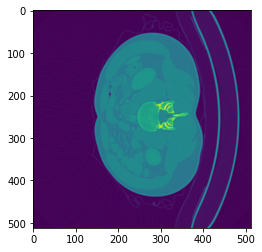

In [84]:
img_test = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID6/image_280.npy')
plt.imshow(img_test)
plt.show()

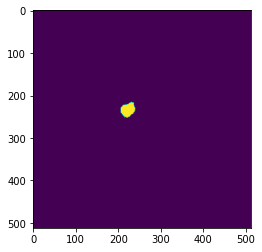

In [83]:
img_test = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID6/ID6_composite_mask_280.npy')
plt.imshow(img_test)
plt.show()

In [96]:
testing_image2 = np.load('/content/content/less_empties/test_new/NIFTI_PATIENT_ID6/image_280.npy')
testing_image2 = cv2.resize(testing_image2, dsize=(500, 500))
testing_image2 = cv2.merge([testing_image2,testing_image2,testing_image2])

In [97]:
new_testing_image2 = np.expand_dims(testing_image2, axis=0)
new_testing_image2.shape

(1, 500, 500, 3)

In [102]:
prediction2 = Model_.predict(new_testing_image2)
a2 = np.squeeze(prediction2, axis=0)
a2.shape

(500, 500, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


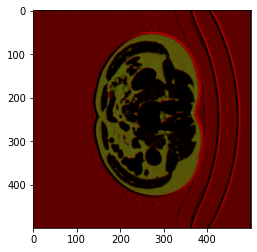

In [103]:
plt.imshow(a2)
plt.show()

##predicting a test image

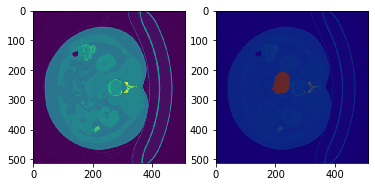

In [106]:
#the actual image to predict (with the tumor in red)
im = np.load('/content/content/less_empties/train_new/ID2/image_512.npy')
immask = np.load('/content/content/less_empties/train_new/ID2/ID2_composite_mask_512.npy')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, interpolation='none')
plt.imshow(immask, 'jet', interpolation='none', alpha=0.7)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


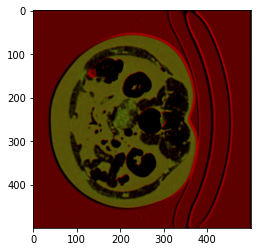

In [105]:
train_image = np.load('/content/content/less_empties/train_new/ID2/image_512.npy')
train_image = cv2.resize(train_image, dsize=(500, 500))
train_image = cv2.merge([train_image,train_image,train_image])
new_train_image = np.expand_dims(train_image, axis=0)
prediction3 = Model_.predict(new_train_image)
a3 = np.squeeze(prediction3, axis=0)
plt.imshow(a3)
plt.show()